In [ ]:
!pip3 install torch

In [ ]:
!pip3 install torchvision

In [ ]:
!pip3 install tqdm

In [ ]:
import torch
from torch import nn
from torch import optim
from torchvision.transforms import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import numpy as np
from os.path import join
from google.colab import drive
import pickle

In [ ]:

drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


torch.Size([3, 32, 32])


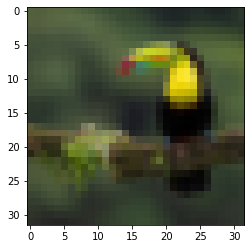

In [ ]:
transform = transforms.Compose([
                                transforms.Resize((32, 32)),
                                transforms.ToTensor()
])

flat_img = 3072  #32×32×3 --size of flattened image

img = Image.open('/content/drive/My Drive/bird.jpg')
real_img = transform(img)

torch.manual_seed(2)
fake_img = torch.rand(1, 100)

plt.imshow(np.transpose(real_img.numpy(), (1, 2, 0)))
print(real_img.size())

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Sequential(
        nn.Linear(flat_img, 10000),
        nn.ReLU(),
        nn.Linear(10000, 1),
        nn.Sigmoid()
    )

  def forward(self, img):
    img = img.view(1, -1)
    out = self.linear(img)

    return out

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Sequential(
        nn.Linear(100, 10000),
        nn.LeakyReLU(),
        nn.Linear(10000, 4000),
        nn.LeakyReLU(),
        nn.Linear(4000, flat_img)
    )

  def forward(self, latent_space):
    latent_space = latent_space.view(1, -1)
    out = self.linear(latent_space)

    return out

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

discr = Discriminator().to(device)
gen = Generator().to(device)

opt_d = optim.SGD(discr.parameters(), lr=0.001, momentum=0.9)
opt_g = optim.SGD(gen.parameters(), lr=0.001, momentum=0.9)

criterion = nn.BCELoss()

In [ ]:
epochs = 500
discr_e = 4 
gen_e = 3

#whole model training starts here
for epoch in tqdm(range(epochs), total=epochs):

  #discriminator training
  for k in range(discr_e):
    opt_d.zero_grad()

    out_d1 = discr(real_img.to(device))
    #loss for real image
    loss_d1 = criterion(out_d1, torch.ones((1, 1)).to(device))
    loss_d1.backward()

    out_d2 = gen(fake_img.to(device)).detach()
    #loss for fake image
    loss_d2 = criterion(discr(out_d2.to(device)), torch.zeros((1, 1)).to(device))
    loss_d2.backward()

    opt_d.step()

  #generator training
  for i in range(gen_e):
    opt_g.zero_grad()
    
    out_g = gen(fake_img.to(device))
    
    #Binary cross entropy loss
    #loss_g =  criterion(discr(out_g.to(device)), torch.ones(1, 1).to(device))

    #----Loss function in the GAN paper
    #[log(1 - D(G(z)))]
    loss_g = torch.log(1.0 - (discr(out_g.to(device)))) 
    loss_g.backward()

    opt_g.step()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


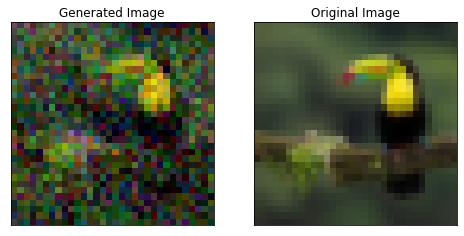

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.title("Generated Image")
plt.xticks([])
plt.yticks([])
plt.imshow(np.transpose(out_g.resize(3, 32, 32).cpu().detach().numpy(), (1, 2, 0)))

plt.subplot(1, 2, 2)
plt.title("Original Image")
plt.xticks([])
plt.yticks([])
plt.imshow(np.transpose(real_img.numpy(), (1, 2, 0)))
plt.show()

In [3]:
!pip3 install utils

In [13]:
!pip3 install utils.coco.coco

ERROR: Could not find a version that satisfies the requirement utils.coco.coco (from versions: none)
ERROR: No matching distribution found for utils.coco.coco


In [10]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

from utils.coco.coco import COCO
from utils.vocabulary import Vocabulary

class DataSet(object):
    def __init__(self,
                 image_ids,
                 image_files,
                 batch_size,
                 word_idxs=None,
                 masks=None,
                 is_train=False,
                 shuffle=False):
        self.image_ids = np.array(image_ids)
        self.image_files = np.array(image_files)
        self.word_idxs = np.array(word_idxs)
        self.masks = np.array(masks)
        self.batch_size = batch_size
        self.is_train = is_train
        self.shuffle = shuffle
        self.setup()

    def setup(self):
        """ Setup the dataset. """
        self.count = len(self.image_ids)
        self.num_batches = int(np.ceil(self.count * 1.0 / self.batch_size))
        self.fake_count = self.num_batches * self.batch_size - self.count
        self.idxs = list(range(self.count))
        self.reset()

    def reset(self):
        """ Reset the dataset. """
        self.current_idx = 0
        if self.shuffle:
            np.random.shuffle(self.idxs)

    def next_batch(self):
        """ Fetch the next batch. """
        assert self.has_next_batch()

        if self.has_full_next_batch():
            start, end = self.current_idx, \
                         self.current_idx + self.batch_size
            current_idxs = self.idxs[start:end]
        else:
            start, end = self.current_idx, self.count
            current_idxs = self.idxs[start:end] + \
                           list(np.random.choice(self.count, self.fake_count))

        image_files = self.image_files[current_idxs]
        if self.is_train:
            word_idxs = self.word_idxs[current_idxs]
            masks = self.masks[current_idxs]
            self.current_idx += self.batch_size
            return image_files, word_idxs, masks
        else:
            self.current_idx += self.batch_size
            return image_files

    def has_next_batch(self):
        """ Determine whether there is a batch left. """
        return self.current_idx < self.count

    def has_full_next_batch(self):
        """ Determine whether there is a full batch left. """
        return self.current_idx + self.batch_size <= self.count

def prepare_train_data(config):
    """ Prepare the data for training the model. """
    coco = COCO(config.train_caption_file)
    coco.filter_by_cap_len(config.max_caption_length)

    print("Building the vocabulary...")
    vocabulary = Vocabulary(config.vocabulary_size)
    if not os.path.exists(config.vocabulary_file):
        vocabulary.build(coco.all_captions())
        vocabulary.save(config.vocabulary_file)
    else:
        vocabulary.load(config.vocabulary_file)
    print("Vocabulary built.")
    print("Number of words = %d" %(vocabulary.size))

    coco.filter_by_words(set(vocabulary.words))

    print("Processing the captions...")
    if not os.path.exists(config.temp_annotation_file):
        captions = [coco.anns[ann_id]['caption'] for ann_id in coco.anns]
        image_ids = [coco.anns[ann_id]['image_id'] for ann_id in coco.anns]
        image_files = [os.path.join(config.train_image_dir,
                                    coco.imgs[image_id]['file_name'])
                                    for image_id in image_ids]
        annotations = pd.DataFrame({'image_id': image_ids,
                                    'image_file': image_files,
                                    'caption': captions})
        annotations.to_csv(config.temp_annotation_file)
    else:
        annotations = pd.read_csv(config.temp_annotation_file)
        captions = annotations['caption'].values
        image_ids = annotations['image_id'].values
        image_files = annotations['image_file'].values

    if not os.path.exists(config.temp_data_file):
        word_idxs = []
        masks = []
        for caption in tqdm(captions):
            current_word_idxs_ = vocabulary.process_sentence(caption)
            current_num_words = len(current_word_idxs_)
            current_word_idxs = np.zeros(config.max_caption_length,
                                         dtype = np.int32)
            current_masks = np.zeros(config.max_caption_length)
            current_word_idxs[:current_num_words] = np.array(current_word_idxs_)
            current_masks[:current_num_words] = 1.0
            word_idxs.append(current_word_idxs)
            masks.append(current_masks)
        word_idxs = np.array(word_idxs)
        masks = np.array(masks)
        data = {'word_idxs': word_idxs, 'masks': masks}
        np.save(config.temp_data_file, data)
    else:
        data = np.load(config.temp_data_file).item()
        word_idxs = data['word_idxs']
        masks = data['masks']
    print("Captions processed.")
    print("Number of captions = %d" %(len(captions)))

    print("Building the dataset...")
    dataset = DataSet(image_ids,
                      image_files,
                      config.batch_size,
                      word_idxs,
                      masks,
                      True,
                      True)
    print("Dataset built.")
    return dataset

def prepare_eval_data(config):
    """ Prepare the data for evaluating the model. """
    coco = COCO(config.eval_caption_file)
    image_ids = list(coco.imgs.keys())
    image_files = [os.path.join(config.eval_image_dir,
                                coco.imgs[image_id]['file_name'])
                                for image_id in image_ids]

    print("Building the vocabulary...")
    if os.path.exists(config.vocabulary_file):
        vocabulary = Vocabulary(config.vocabulary_size,
                                config.vocabulary_file)
    else:
        vocabulary = build_vocabulary(config)
    print("Vocabulary built.")
    print("Number of words = %d" %(vocabulary.size))

    print("Building the dataset...")
    dataset = DataSet(image_ids, image_files, config.batch_size)
    print("Dataset built.")
    return coco, dataset, vocabulary

def prepare_test_data(config):
    """ Prepare the data for testing the model. """
    files = os.listdir(config.test_image_dir)
    image_files = [os.path.join(config.test_image_dir, f) for f in files
        if f.lower().endswith('.jpg') or f.lower().endswith('.jpeg')]
    image_ids = list(range(len(image_files)))

    print("Building the vocabulary...")
    if os.path.exists(config.vocabulary_file):
        vocabulary = Vocabulary(config.vocabulary_size,
                                config.vocabulary_file)
    else:
        vocabulary = build_vocabulary(config)
    print("Vocabulary built.")
    print("Number of words = %d" %(vocabulary.size))

    print("Building the dataset...")
    dataset = DataSet(image_ids, image_files, config.batch_size)
    print("Dataset built.")
    return dataset, vocabulary

def build_vocabulary(config):
    """ Build the vocabulary from the training data and save it to a file. """
    coco = COCO(config.train_caption_file)
    coco.filter_by_cap_len(config.max_caption_length)

    vocabulary = Vocabulary(config.vocabulary_size)
    vocabulary.build(coco.all_captions())
    vocabulary.save(config.vocabulary_file)
    return vocabulary

ModuleNotFoundError: ignored

In [17]:
!pip3 install lib.defaultFlags

ERROR: Could not find a version that satisfies the requirement lib.defaultFlags (from versions: none)
ERROR: No matching distribution found for lib.defaultFlags


In [14]:
import numpy as np
import os
import h5py
import tensorflow as tf

from lib.defaultFlags import defaultFlags
from lib.TEResNet import TEResNet
from lib.TEGAN import TEGAN
from lib.readTFRecord import getTFRecordFilenamesIn 

FLAGS = defaultFlags()

# Check the output_dir is given
if FLAGS.output_dir is None:
    raise ValueError('The output directory is needed')

# Check the output directory to save the checkpoint
if not os.path.exists(FLAGS.output_dir):
    os.mkdir(FLAGS.output_dir)

# Check the summary_dir is given
if FLAGS.summary_dir is None:
    raise ValueError('The summary directory is needed')

# Check the summary directory to save the event
if not os.path.exists(FLAGS.summary_dir):
    os.mkdir(FLAGS.summary_dir)

filenames_train = getTFRecordFilenamesIn(FLAGS.train_dir)
if len(filenames_train) % FLAGS.batch_size != 0:
    raise RuntimeError("Tread with CAUTION! Training dataset size is not a multiple of batch_size")

filenames_dev = getTFRecordFilenamesIn(FLAGS.dev_dir)
if len(filenames_dev) % FLAGS.batch_size != 0:
    raise RuntimeError("Tread with CAUTION! Training dataset size is not a multiple of batch_size")

if FLAGS.task == 'TEResNet':
    net = TEResNet(filenames_train, filenames_dev, FLAGS)
elif FLAGS.task == 'TEGAN':
    net = TEGAN(filenames_train, filenames_dev, FLAGS)
else:
    raise ValueError('Need to specify FLAGS.task to be TEResNet or TEGAN')

with tf.Session() as sess:
    print("--------------- {} mode -----------------".format(FLAGS.mode))
    net.initialize(sess)    
    print("Finished initializing :D")

    if FLAGS.mode == 'train':
        net.optimize(sess)

    elif FLAGS.mode == 'test':
        filenames_test = getTFRecordFilenamesIn(FLAGS.test_dir)
        output = net.evaluate(sess, [ filenames_test[0] ])
        losses = net.evaluate_losses(sess, filenames_test)

        filename_out = os.path.basename(filenames_test[0]).replace('.tfrecord','.h5')
        print("Saving test data to {}".format(os.path.join(FLAGS.output_dir, filename_out)))
        h5f = h5py.File(os.path.join(FLAGS.output_dir, filename_out), 'w')
        h5f.create_dataset('HR', data=output[0][0])
        h5f.create_dataset('LR', data=output[0][1])
        h5f.create_dataset('output', data=output[0][2])
        h5f.close()

        for loss, val in losses.items():
            print("{0:26s} = {1:0.6f}".format(loss,np.mean(val)))
    print("--------------- ******** -----------------")

ModuleNotFoundError: ignored

In [25]:
!pip3 install pylearn3

ERROR: Could not find a version that satisfies the requirement pylearn3 (from versions: none)
ERROR: No matching distribution found for pylearn3


In [26]:
! pip3 install theano

In [27]:
!pip3 install pylearn2.linear.conv2d_c01b

ERROR: Could not find a version that satisfies the requirement pylearn2.linear.conv2d_c01b (from versions: none)
ERROR: No matching distribution found for pylearn2.linear.conv2d_c01b


In [30]:
!pip3 install pylearn3

ERROR: Could not find a version that satisfies the requirement pylearn3 (from versions: none)
ERROR: No matching distribution found for pylearn3


In [23]:
import numpy as np

from theano.compat import OrderedDict
from theano import tensor as T

from pylearn2.linear.conv2d_c01b import make_random_conv2D
from pylearn2.models import Model
from pylearn2.models.maxout import check_cuda # TODO: import from original path
from pylearn2.models.mlp import Layer
#from pylearn2.models.maxout import py_integer_types # TODO: import from orig path
from pylearn2.space import Conv2DSpace
from pylearn2.utils import sharedX

logger = logging.getLogger(__name__)

class Deconv(Layer):
    def __init__(self,
                 num_channels,
                 kernel_shape,
                 layer_name,
                 irange=None,
                 init_bias=0.,
                 W_lr_scale=None,
                 b_lr_scale=None,
                 pad_out=0,
                 fix_kernel_shape=False,
                 partial_sum=1,
                 tied_b=False,
                 max_kernel_norm=None,
                 output_stride=(1, 1)):
        check_cuda(str(type(self)))
        super(Deconv, self).__init__()

        detector_channels = num_channels

        self.__dict__.update(locals())
        del self.self

    @functools.wraps(Model.get_lr_scalers)
    def get_lr_scalers(self):

        if not hasattr(self, 'W_lr_scale'):
            self.W_lr_scale = None

        if not hasattr(self, 'b_lr_scale'):
            self.b_lr_scale = None

        rval = OrderedDict()

        if self.W_lr_scale is not None:
            W, = self.transformer.get_params()
            rval[W] = self.W_lr_scale

        if self.b_lr_scale is not None:
            rval[self.b] = self.b_lr_scale

        return rval

    def set_input_space(self, space):
        """
        Tells the layer to use the specified input space.
        This resets parameters! The kernel tensor is initialized with the
        size needed to receive input from this space.
        Parameters
        ----------
        space : Space
            The Space that the input will lie in.
        """

        setup_deconv_detector_layer_c01b(layer=self,
                                  input_space=space,
                                  rng=self.mlp.rng)

        rng = self.mlp.rng

        detector_shape = self.detector_space.shape


        self.output_space = self.detector_space

        logger.info('Output space: {0}'.format(self.output_space.shape))

    def _modify_updates(self, updates):
        """
        Replaces the values in `updates` if needed to enforce the options set
        in the __init__ method, including `max_kernel_norm`.
        Parameters
        ----------
        updates : OrderedDict
            A dictionary mapping parameters (including parameters not
            belonging to this model) to updated values of those parameters.
            The dictionary passed in contains the updates proposed by the
            learning algorithm. This function modifies the dictionary
            directly. The modified version will be compiled and executed
            by the learning algorithm.
        """

        if self.max_kernel_norm is not None:
            W, = self.transformer.get_params()
            if W in updates:
                updated_W = updates[W]
                row_norms = T.sqrt(T.sum(T.sqr(updated_W), axis=(0, 1, 2)))
                desired_norms = T.clip(row_norms, 0, self.max_kernel_norm)
                scales = desired_norms / (1e-7 + row_norms)
                updates[W] = (updated_W * scales.dimshuffle('x', 'x', 'x', 0))

    @functools.wraps(Model.get_params)
    def get_params(self):
        assert self.b.name is not None
        W, = self.transformer.get_params()
        assert W.name is not None
        rval = self.transformer.get_params()
        assert not isinstance(rval, set)
        rval = list(rval)
        assert self.b not in rval
        rval.append(self.b)
        return rval

    @functools.wraps(Layer.get_weight_decay)
    def get_weight_decay(self, coeff):
        if isinstance(coeff, str):
            coeff = float(coeff)
        assert isinstance(coeff, float) or hasattr(coeff, 'dtype')
        W, = self.transformer.get_params()
        return coeff * T.sqr(W).sum()

    @functools.wraps(Layer.set_weights)
    def set_weights(self, weights):
        W, = self.transformer.get_params()
        W.set_value(weights)

    @functools.wraps(Layer.set_biases)
    def set_biases(self, biases):
        self.b.set_value(biases)

    @functools.wraps(Layer.get_biases)
    def get_biases(self):
        return self.b.get_value()

    @functools.wraps(Model.get_weights_topo)
    def get_weights_topo(self):
        return self.transformer.get_weights_topo()

    @functools.wraps(Layer.get_monitoring_channels)
    def get_layer_monitoring_channels(self, state_below=None, state=None, targets=None):

        W, = self.transformer.get_params()

        assert W.ndim == 4

        sq_W = T.sqr(W)

        row_norms = T.sqrt(sq_W.sum(axis=(0, 1, 2)))

        P = state

        rval = OrderedDict()

        vars_and_prefixes = [(P, '')]

        for var, prefix in vars_and_prefixes:
            if not hasattr(var, 'ndim') or var.ndim != 4:
                print ("expected 4D tensor, got ")
                print (var)
                print (type(var))
                if isinstance(var, tuple):
                    print ("tuple length: ", len(var))
                assert False
            v_max = var.max(axis=(1, 2, 3))
            v_min = var.min(axis=(1, 2, 3))
            v_mean = var.mean(axis=(1, 2, 3))
            v_range = v_max - v_min

            # max_x.mean_u is "the mean over *u*nits of the max over
            # e*x*amples" The x and u are included in the name because
            # otherwise its hard to remember which axis is which when reading
            # the monitor I use inner.outer rather than outer_of_inner or
            # something like that because I want mean_x.* to appear next to
            # each other in the alphabetical list, as these are commonly
            # plotted together
            for key, val in [('max_x.max_u',    v_max.max()),
                             ('max_x.mean_u',   v_max.mean()),
                             ('max_x.min_u',    v_max.min()),
                             ('min_x.max_u',    v_min.max()),
                             ('min_x.mean_u',   v_min.mean()),
                             ('min_x.min_u',    v_min.min()),
                             ('range_x.max_u',  v_range.max()),
                             ('range_x.mean_u', v_range.mean()),
                             ('range_x.min_u',  v_range.min()),
                             ('mean_x.max_u',   v_mean.max()),
                             ('mean_x.mean_u',  v_mean.mean()),
                             ('mean_x.min_u',   v_mean.min())]:
                rval[prefix+key] = val

        rval.update(OrderedDict([('kernel_norms_min',  row_norms.min()),
                            ('kernel_norms_mean', row_norms.mean()),
                            ('kernel_norms_max',  row_norms.max()), ]))

        return rval

    @functools.wraps(Layer.fprop)
    def fprop(self, state_below):
        check_cuda(str(type(self)))

        self.input_space.validate(state_below)

        z = self.transformer.lmul_T(state_below)

        self.output_space.validate(z)

        if not hasattr(self, 'tied_b'):
            self.tied_b = False
        if self.tied_b:
            b = self.b.dimshuffle(0, 'x', 'x', 'x')
        else:
            b = self.b.dimshuffle(0, 1, 2, 'x')

        return z + b



def setup_deconv_detector_layer_c01b(layer, input_space, rng, irange="not specified"):
    """
    layer. This function sets up only the detector layer.
    Does the following:
    * raises a RuntimeError if cuda is not available
    * sets layer.input_space to input_space
    * sets up addition of dummy channels for compatibility with cuda-convnet:
      - layer.dummy_channels: # of dummy channels that need to be added
        (You might want to check this and raise an Exception if it's not 0)
      - layer.dummy_space: The Conv2DSpace representing the input with dummy
        channels added
    * sets layer.detector_space to the space for the detector layer
    * sets layer.transformer to be a Conv2D instance
    * sets layer.b to the right value
    Parameters
    ----------
    layer : object
        Any python object that allows the modifications described below and
        has the following attributes:
          * pad : int describing amount of zero padding to add
          * kernel_shape : 2-element tuple or list describing spatial shape of
            kernel
          * fix_kernel_shape : bool, if true, will shrink the kernel shape to
            make it feasible, as needed (useful for hyperparameter searchers)
          * detector_channels : The number of channels in the detector layer
          * init_bias : numeric constant added to a tensor of zeros to
            initialize the bias
          * tied_b : If true, biases are shared across all spatial locations
    input_space : WRITEME
        A Conv2DSpace to be used as input to the layer
    rng : WRITEME
        A numpy RandomState or equivalent
    """

    if irange != "not specified":
        raise AssertionError(
            "There was a bug in setup_detector_layer_c01b."
            "It uses layer.irange instead of the irange parameter to the "
            "function. The irange parameter is now disabled by this "
            "AssertionError, so that this error message can alert you that "
            "the bug affected your code and explain why the interface is "
            "changing. The irange parameter to the function and this "
            "error message may be removed after April 21, 2014."
        )

    # Use "self" to refer to layer from now on, so we can pretend we're
    # just running in the set_input_space method of the layer
    self = layer

    # Make sure cuda is available
    check_cuda(str(type(self)))

    # Validate input
    if not isinstance(input_space, Conv2DSpace):
        raise TypeError("The input to a convolutional layer should be a "
                        "Conv2DSpace, but layer " + self.layer_name + " got " +
                        str(type(self.input_space)))

    if not hasattr(self, 'detector_channels'):
        raise ValueError("layer argument must have a 'detector_channels' "
                         "attribute specifying how many channels to put in "
                         "the convolution kernel stack.")

    # Store the input space
    self.input_space = input_space

    # Make sure number of channels is supported by cuda-convnet
    # (multiple of 4 or <= 3)
    # If not supported, pad the input with dummy channels
    ch = self.detector_channels
    rem = ch % 4
    if ch > 3 and rem != 0:
        raise NotImplementedError("Need to do dummy channels on the output")
    #    self.dummy_channels = 4 - rem
    #else:
    #    self.dummy_channels = 0
    #self.dummy_space = Conv2DSpace(
    #    shape=input_space.shape,
    #    channels=input_space.num_channels + self.dummy_channels,
    #    axes=('c', 0, 1, 'b')
    #)

    if hasattr(self, 'output_stride'):
        kernel_stride = self.output_stride
    else:
        assert False # not sure if I got the name right, remove this assert if I did
        kernel_stride = [1, 1]


    #o_sh = int(np.ceil((i_sh + 2. * self.pad - k_sh) / float(k_st))) + 1
    #o_sh -1 = np.ceil((i_sh + 2. * self.pad - k_sh) / float(k_st))
    #inv_ceil(o_sh -1) = (i_sh + 2. * self.pad - k_sh) / float(k_st)
    #float(k_st) inv_cel(o_sh -1) = (i_sh + 2 * self.pad -k_sh)
    # i_sh = k_st inv_ceil(o_sh-1) - 2 * self.pad + k_sh

    output_shape = \
        [k_st * (i_sh - 1) - 2 * self.pad_out + k_sh
         for i_sh, k_sh, k_st in zip(self.input_space.shape,
                                     self.kernel_shape, kernel_stride)]


    if self.input_space.num_channels < 16:
        raise ValueError("Cuda-convnet requires the input to lmul_T to have "
                         "at least 16 channels.")

    self.detector_space = Conv2DSpace(shape=output_shape,
                                      num_channels=self.detector_channels,
                                      axes=('c', 0, 1, 'b'))

    if hasattr(self, 'partial_sum'):
        partial_sum = self.partial_sum
    else:
        partial_sum = 1

    if hasattr(self, 'sparse_init') and self.sparse_init is not None:
        self.transformer = \
            checked_call(make_sparse_random_conv2D,
                         OrderedDict([('num_nonzero', self.sparse_init),
                                      ('input_space', self.detector_space),
                                      ('output_space', self.input_space),
                                      ('kernel_shape', self.kernel_shape),
                                      ('pad', self.pad),
                                      ('partial_sum', partial_sum),
                                      ('kernel_stride', kernel_stride),
                                      ('rng', rng)]))
    else:
        self.transformer = make_random_conv2D(
            irange=self.irange,
            input_axes=self.detector_space.axes,
            output_axes=self.input_space.axes,
            input_channels=self.detector_space.num_channels,
            output_channels=self.input_space.num_channels,
            kernel_shape=self.kernel_shape,
            pad=self.pad_out,
            partial_sum=partial_sum,
            kernel_stride=kernel_stride,
            rng=rng,
            input_shape=self.detector_space.shape
        )

    W, = self.transformer.get_params()
    W.name = self.layer_name + '_W'

    if self.tied_b:
        self.b = sharedX(np.zeros(self.detector_space.num_channels) +
                         self.init_bias)
    else:
        self.b = sharedX(self.detector_space.get_origin() + self.init_bias)
    self.b.name = self.layer_name + '_b'

    logger.info('Input shape: {0}'.format(self.input_space.shape))
    print (layer.layer_name + ' detector space: {0}'.format(self.detector_space.shape))

ModuleNotFoundError: ignored

In [33]:
!pip3 install tokenization

In [37]:
!pip3 install utils

In [39]:
!pip3 install git+git://github.com/keras-team/keras.git --upgrade --no-deps

  Cloning git://github.com/keras-team/keras.git to /tmp/pip-req-build-mtzl6rea
  Running command git clone -q git://github.com/keras-team/keras.git /tmp/pip-req-build-mtzl6rea
  Created wheel for Keras: filename=Keras-2.4.3-cp36-none-any.whl size=36257 sha256=50364484f89cb37a9d5b32500c4e1c40e110d4fa391d173cbaccf3bd2348e95d
  Stored in directory: /tmp/pip-ephem-wheel-cache-8ltirtbt/wheels/e6/02/ad/5e8e1a5824af71082e2260fe7e2eaa1b745c34706e6ff0a14b
Successfully built Keras
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [40]:
import argparse
import multiprocessing
import os
import random
import time
import tensorflow.compat.v1 as tf

import tokenization
import utils


def create_int_feature(values):
  feature = tf.train.Feature(int64_list=tf.train.Int64List(value=list(values)))
  return feature


class ExampleBuilder(object):
  """Given a stream of input text, creates pretraining examples."""

  def __init__(self, tokenizer, max_length):
    self._tokenizer = tokenizer
    self._current_sentences = []
    self._current_length = 0
    self._max_length = max_length
    self._target_length = max_length

  def add_line(self, line):
    """Adds a line of text to the current example being built."""
    line = line.strip().replace("\n", " ")
    if (not line) and self._current_length != 0:  # empty lines separate docs
      return self._create_example()
    bert_tokens = self._tokenizer.tokenize(line)
    bert_tokids = self._tokenizer.convert_tokens_to_ids(bert_tokens)
    self._current_sentences.append(bert_tokids)
    self._current_length += len(bert_tokids)
    if self._current_length >= self._target_length:
      return self._create_example()
    return None

  def _create_example(self):
    """Creates a pre-training example from the current list of sentences."""
    # small chance to only have one segment as in classification tasks
    if random.random() < 0.1:
      first_segment_target_length = 100000
    else:
      # -3 due to not yet having [CLS]/[SEP] tokens in the input text
      first_segment_target_length = (self._target_length - 3) // 2

    first_segment = []
    second_segment = []
    for sentence in self._current_sentences:
      # the sentence goes to the first segment if (1) the first segment is
      # empty, (2) the sentence doesn't put the first segment over length or
      # (3) 50% of the time when it does put the first segment over length
      if (len(first_segment) == 0 or
          len(first_segment) + len(sentence) < first_segment_target_length or
          (len(second_segment) == 0 and
           len(first_segment) < first_segment_target_length and
           random.random() < 0.5)):
        first_segment += sentence
      else:
        second_segment += sentence

    # trim to max_length while accounting for not-yet-added [CLS]/[SEP] tokens
    first_segment = first_segment[:self._max_length - 2]
    second_segment = second_segment[:max(0, self._max_length -
                                         len(first_segment) - 3)]

    # prepare to start building the next example
    self._current_sentences = []
    self._current_length = 0
    # small chance for random-length instead of max_length-length example
    if random.random() < 0.05:
      self._target_length = random.randint(5, self._max_length)
    else:
      self._target_length = self._max_length

    return self._make_tf_example(first_segment, second_segment)

  def _make_tf_example(self, first_segment, second_segment):
    """Converts two "segments" of text into a tf.train.Example."""
    vocab = self._tokenizer.vocab
    input_ids = [vocab["[CLS]"]] + first_segment + [vocab["[SEP]"]]
    segment_ids = [0] * len(input_ids)
    if second_segment:
      input_ids += second_segment + [vocab["[SEP]"]]
      segment_ids += [1] * (len(second_segment) + 1)
    input_mask = [1] * len(input_ids)
    input_ids += [0] * (self._max_length - len(input_ids))
    input_mask += [0] * (self._max_length - len(input_mask))
    segment_ids += [0] * (self._max_length - len(segment_ids))
    tf_example = tf.train.Example(features=tf.train.Features(feature={
        "input_ids": create_int_feature(input_ids),
        "input_mask": create_int_feature(input_mask),
        "segment_ids": create_int_feature(segment_ids)
    }))
    return tf_example


class ExampleWriter(object):
  """Writes pre-training examples to disk."""

  def __init__(self, job_id, vocab_file, output_dir, max_seq_length,
               num_jobs, blanks_separate_docs, do_lower_case,
               num_out_files=1000):
    self._blanks_separate_docs = blanks_separate_docs
    tokenizer = tokenization.FullTokenizer(
        vocab_file=vocab_file,
        do_lower_case=do_lower_case)
    self._example_builder = ExampleBuilder(tokenizer, max_seq_length)
    self._writers = []
    for i in range(num_out_files):
      if i % num_jobs == job_id:
        output_fname = os.path.join(
            output_dir, "pretrain_data.tfrecord-{:}-of-{:}".format(
                i, num_out_files))
        self._writers.append(tf.io.TFRecordWriter(output_fname))
    self.n_written = 0

  def write_examples(self, input_file):
    """Writes out examples from the provided input file."""
    with tf.io.gfile.GFile(input_file) as f:
      for line in f:
        line = line.strip()
        if line or self._blanks_separate_docs:
          example = self._example_builder.add_line(line)
          if example:
            self._writers[self.n_written % len(self._writers)].write(
                example.SerializeToString())
            self.n_written += 1
      example = self._example_builder.add_line("")
      if example:
        self._writers[self.n_written % len(self._writers)].write(
            example.SerializeToString())
        self.n_written += 1

  def finish(self):
    for writer in self._writers:
      writer.close()


def write_examples(job_id, args):
  """A single process creating and writing out pre-processed examples."""

  def log(*args):
    msg = " ".join(map(str, args))
    print("Job {}:".format(job_id), msg)

  log("Creating example writer")
  example_writer = ExampleWriter(
      job_id=job_id,
      vocab_file=args.vocab_file,
      output_dir=args.output_dir,
      max_seq_length=args.max_seq_length,
      num_jobs=args.num_processes,
      blanks_separate_docs=args.blanks_separate_docs,
      do_lower_case=args.do_lower_case
  )
  log("Writing tf examples")
  fnames = sorted(tf.io.gfile.listdir(args.corpus_dir))
  fnames = [f for (i, f) in enumerate(fnames)
            if i % args.num_processes == job_id]
  random.shuffle(fnames)
  start_time = time.time()
  for file_no, fname in enumerate(fnames):
    if file_no > 0:
      elapsed = time.time() - start_time
      log("processed {:}/{:} files ({:.1f}%), ELAPSED: {:}s, ETA: {:}s, "
          "{:} examples written".format(
              file_no, len(fnames), 100.0 * file_no / len(fnames), int(elapsed),
              int((len(fnames) - file_no) / (file_no / elapsed)),
              example_writer.n_written))
    example_writer.write_examples(os.path.join(args.corpus_dir, fname))
  example_writer.finish()
  log("Done!")


def main():
  parser = argparse.ArgumentParser(description=__doc__)
  parser.add_argument("--corpus-dir", required=True,
                      help="Location of pre-training text files.")
  parser.add_argument("--vocab-file", required=True,
                      help="Location of vocabulary file.")
  parser.add_argument("--output-dir", required=True,
                      help="Where to write out the tfrecords.")
  parser.add_argument("--max-seq-length", default=128, type=int,
                      help="Number of tokens per example.")
  parser.add_argument("--num-processes", default=1, type=int,
                      help="Parallelize across multiple processes.")
  parser.add_argument("--blanks-separate-docs", default=True, type=bool,
                      help="Whether blank lines indicate document boundaries.")
  parser.add_argument("--do-lower-case", dest='do_lower_case',
                      action='store_true', help="Lower case input text.")
  parser.add_argument("--no-lower-case", dest='do_lower_case',
                      action='store_false', help="Don't lower case input text.")
  parser.set_defaults(do_lower_case=True)
  args = parser.parse_args()

  utils.rmkdir(args.output_dir)
  if args.num_processes == 1:
    write_examples(0, args)
  else:
    jobs = []
    for i in range(args.num_processes):
      job = multiprocessing.Process(target=write_examples, args=(i, args))
      jobs.append(job)
      job.start()
    for job in jobs:
      job.join()


if __name__ == "__main__":
  main()

   

usage: ipykernel_launcher.py [-h] --corpus-dir CORPUS_DIR --vocab-file
                             VOCAB_FILE --output-dir OUTPUT_DIR
                             [--max-seq-length MAX_SEQ_LENGTH]
                             [--num-processes NUM_PROCESSES]
                             [--blanks-separate-docs BLANKS_SEPARATE_DOCS]
                             [--do-lower-case] [--no-lower-case]
ipykernel_launcher.py: error: the following arguments are required: --corpus-dir, --vocab-file, --output-dir


SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
import argparse

import torch
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random

from dcgan import Generator

parser = argparse.ArgumentParser()
parser.add_argument('-load_path', default='model/model_final.pth', help='Checkpoint to load path from')
parser.add_argument('-num_output', default=64, help='Number of generated outputs')
args = parser.parse_args()

# Load the checkpoint file.
state_dict = torch.load(args.load_path)

# Set the device to run on: GPU or CPU.
device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
# Get the 'params' dictionary from the loaded state_dict.
params = state_dict['params']

# Create the generator network.
netG = Generator(params).to(device)
# Load the trained generator weights.
netG.load_state_dict(state_dict['generator'])
print(netG)

print(args.num_output)
# Get latent vector Z from unit normal distribution.
noise = torch.randn(int(args.num_output), params['nz'], 1, 1, device=device)

# Turn off gradient calculation to speed up the process.
with torch.no_grad():
	# Get generated image from the noise vector using
	# the trained generator.
    generated_img = netG(noise).detach().cpu()

# Display the generated image.
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(generated_img, padding=2, normalize=True), (1,2,0)))

plt.show()